In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


In [2]:
e = exp.load('iter_exps11_3iters', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.091617465

In [3]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

IndexError: list index out of range

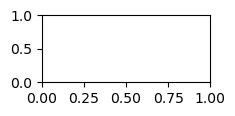

In [4]:
# plot the weights in a 4x4 grid
fig = plt.figure(figsize=(10,4))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(e.trials[0].model.networks[0].layers[1].weights[:,:,i])
    ax.axis('off')

In [ ]:
e.trials[0].model.NDN.plot_filters()

# readout weights

In [ ]:
readout_weights = np.sum(e.trials[0].model.networks[2].layers[0].weights[:,:,:], axis=1)
print(readout_weights.shape)
# make inhibitory weights negative (every 12 weights need to be flipped)
readout_weights[3,:] = -readout_weights[3,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]

# get the mean LLs for just the SUs in k
mean_SU_LLs = np.mean(e.trials[0].LLs[dataset.SUs])

# get the mean LLs for k
mean_LLs = np.mean(e.trials[0].LLs)

fig = plt.figure(figsize=(20,10))
plot.imagesc(readout_weights, cmap='bwr', colrow=False, origin='upper')
plt.title('(mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
plt.axis('off')

# put a vertical line between each experiment
for expt_boundary in expt_boundaries:
    plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)

# put a vertical line between the SUs and the MUs
# get the indices of the SUs where the experiment boundaries are
SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

for SU_boundary in SU_boundaries:
    plt.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
# plot the last SU boundary
plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

layer_boundaries = [0, 4, 20, 36, 52, 68]

# put a horizontal line between each layer
for layer_boundary in layer_boundaries[1:-1]:
    plt.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# projection weights

In [ ]:
proj_weights = e.trials[0].model.networks[1].layers[0].weights
proj_weights[1,:,:] = -proj_weights[1,:,:]
proj_max = np.max(proj_weights)
proj_min = -proj_max

print('Projection weights shape', proj_weights.shape)

e.trials[0].model.NDN.plot_filters()

# make a 2x2 grid
fig = plt.figure(figsize=(25,4))
# put space between the plots
fig.subplots_adjust(wspace=0.2, hspace=0.8)
rows,cols = 2,8
gridspec = fig.add_gridspec(rows,cols)
for i in range(proj_weights.shape[2]):
    row,col = np.unravel_index(i, (rows,cols))
    ax = fig.add_subplot(gridspec[row,col])
    ax.imshow(proj_weights[:,:,i], cmap='bwr', aspect='auto', vmin=proj_min, vmax=proj_max)
    ax.set_title('PROJ Filter '+str(i))
    ax.set_xlabel('Space')
    ax.set_ylabel('Outputs')
plt.show()

# jacobian

In [5]:
results = predict.predict(e.trials[0].model, dataset=dataset[:5], calc_jacobian=True, verbose=True)

num_inps 5
prev_output shape torch.Size([5, 504]) ni 0 NetworkType.normal li 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.04it/s]


torch.Size([5, 504]) --> torch.Size([5, 288])
prev_output shape torch.Size([5, 288]) ni 1 NetworkType.scaffold li 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


torch.Size([5, 288]) --> torch.Size([5, 2304])
prev_output shape torch.Size([5, 2304]) ni 1 NetworkType.scaffold li 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


torch.Size([5, 2304]) --> torch.Size([5, 1728])
li 0 tconv_layer_height 576
accumulated_prev_outputs 2
prev_output shape torch.Size([5, 2304]) ni 2 NetworkType.normal li 0


 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:00<00:00, 13.30it/s]

li 0 tconv_layer_height 576
accumulated_prev_outputs 2
li 0 tconv_layer_height 576
accumulated_prev_outputs 2
li 0 tconv_layer_height 576
accumulated_prev_outputs 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.30it/s]
/home/mattjac/projects/mattjac/v1/./lib/predict.py:131: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - np.sum((robs - pred)**2, axis=0) / np.sum((robs - np.mean(robs))**2, axis=0)


li 0 tconv_layer_height 576
accumulated_prev_outputs 2
li 0 tconv_layer_height 576
accumulated_prev_outputs 2
torch.Size([5, 2304]) --> torch.Size([5, 111])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.35it/s]


# projection layer with smaller filter width

In [ ]:
e12 = exp.load('iter_exps12', experiment_location='experiments', datadir='Mdata')
e12.trials_df

In [ ]:
e12.trials[0].model.NDN.list_parameters()

In [ ]:
lgn = e12.trials[0].model.networks[0].layers[0].weights
lgn[1,:,:] = -lgn[1,:,:]

proj_weights = e12.trials[0].model.networks[1].layers[0].weights
proj_weights[1,:,:] = -proj_weights[1,:,:]
proj_max = np.max(proj_weights)
proj_min = -proj_max

e12.trials[0].model.NDN.plot_filters()

print('LGN weights shape', lgn.shape)
print('Projection weights shape', proj_weights.shape)

# make a 2x2 grid
fig = plt.figure(figsize=(25,4))
# put space between the plots
fig.subplots_adjust(wspace=0.2, hspace=0.8)
rows,cols = 2,8
gridspec = fig.add_gridspec(rows,cols)
for i in range(proj_weights.shape[2]):
    row,col = np.unravel_index(i, (rows,cols))
    ax = fig.add_subplot(gridspec[row,col])
    ax.imshow(proj_weights[:,:,i], cmap='bwr', aspect='auto', vmin=proj_min, vmax=proj_max)
    ax.set_title('PROJ Filter '+str(i))
    ax.set_xlabel('Space')
    ax.set_ylabel('Outputs')
plt.show()


# make a linear approximation of the projection weights by averaging the LGN filters where the weights are
# for each projection filter, copy the LGN filter to the corresponding output weighted by the projection weights

# normalize the projection weights
proj_weights_normalized = proj_weights / abs(np.max(proj_weights))

proj_filters_exc = np.zeros((16,15,11))
proj_filters_inh = np.zeros((16,15,11))
for subunit in range(proj_filters_exc.shape[0]):
    for space in range(proj_filters_exc.shape[1]):
        for exc in range(proj_weights.shape[0]//2):
            proj_filters_exc[subunit, space, :] += lgn[space, :, exc] * proj_weights_normalized[exc, space, subunit]
        for inh in range(proj_weights.shape[0]//2, proj_weights.shape[0]):
            proj_filters_inh[subunit, space, :] += lgn[space, :, inh] * proj_weights_normalized[inh, space, subunit]

exc_max = np.max(proj_filters_exc)
exc_min = -exc_max
inh_max = np.max(proj_filters_inh)
inh_min = -inh_max

# plot the filters
fig = plt.figure(figsize=(25,8))
# put space between the plots
fig.subplots_adjust(wspace=0.3, hspace=0.8)
rows,cols = 4,8
gridspec = fig.add_gridspec(rows,cols)
i = 0
for row in range(0, rows, 2):
    for col in range(cols):
        ax = fig.add_subplot(gridspec[row,col])
        ax.imshow(proj_filters_exc[i,:,:].T, cmap='copper', aspect='auto', origin='lower', alpha=0.5, vmin=exc_min, vmax=exc_max)
        ax.set_title('Exc Filter '+str(i))
        ax.set_xlabel('Space')
        ax.set_ylabel('Time')
        ax = fig.add_subplot(gridspec[row+1,col])
        ax.imshow(proj_filters_inh[i,:,:].T, cmap='bone', aspect='auto', origin='lower', alpha=0.5, vmin=inh_min, vmax=inh_max)
        ax.set_title('Inh Filter '+str(i))
        ax.set_xlabel('Space')
        ax.set_ylabel('Time')
        i += 1
plt.suptitle('Linear Approximation of LGN Filters Weighted by Projection Weights')
plt.show()